# <center> Credit scoring for the microloan organization

## 1. Feature and data explanation

We have data from a micro loan organization. Data includes: applications, status (if application was granted or not) and portfoli snapshorts. Current risk level (ration of default clients) is too much, we need to implement at least basic scorecard to extract the best clients.

Data can be found here https://cloud.mail.ru/public/MTPz/zvoEGUjz9

**applications.csv** - contains information about applications

**status.csv** - contains information if loan was granted or not, and short information about previous applications of client

**portfolio.csv** - snapshot for every day if client was in delinquency or not

**applications.csv:**

Term - term of loan

expired_date - till that date client can accept the loan

loans_amount - amount of loans (rur) that client took

loans_cnt - count of loans that client took

paid_amount - amount of loans (rur) that client paid

paid_cnt - count of loans that client paid

pretention - client has pretention about previous loans (for example, didn't pay the penalties)

location_country - country location of client (from IP address)

location_city - city location of client (from IP address)

app_dt - date of application

verif_data - client verified his data

verif_doc - client verified his document

verif_appl - client verified his photo

verif_addres - client verified his address

doc_date - issue date of passport

client_date - date of registration in the community of microloan organization

credit_status - status of client (2: has active loan, 1: has closed loans, 0: never had loans in the system)

rating, rating2 - ratings in the community of microloan organization

amount_issued - amount of current loan

amount_return - amount of current loan plus interest rate

friends - friends in the community of microloan organization

app_id - id of applications

client_id - id of client

**status.csv**:

comments - comments of staff (usually it means something bad)

decision - if loan was granted or not (1 - granted)

**portfolio.csv**:

report_dt - date of snapshot

delq - if client was in delinquency or not (1 - was)

## 2. Primary data analysis

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from datetime import timedelta, date
import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline

Loading data

In [3]:
status = pd.read_csv('status.csv')
applications = pd.read_csv('applications.csv')
portfolio = pd.read_csv('portfolio.csv')

In [4]:
status.head()

,id,Term,comments,location_country,location_city,app_id,client_id,app_dt,amount_issued,amount_return,decision
0,0,30,0,n\a,NaN,19938,6246,2018-12-15,610.0,854.0,1.0
1,1,20,0,n\a,NaN,19937,6246,2018-12-15,610.0,854.0,1.0
2,2,30,0,Ukraine,Simferopol,19930,19923,2018-12-15,3050.0,3416.0,1.0
3,3,30,0,Russia,Chelyabinsk,19929,19674,2018-12-15,7320.0,7686.0,1.0
4,4,110,0,Russia,Novosibirsk,19928,19529,2018-12-15,2440.0,2928.0,1.0


In [5]:
applications.head()

,id,Term,expired_date,loans_amount,loans_cnt,paid_amount,paid_cnt,pretention,location_country,location_city,...,doc_date,client_date,credit_status,rating,rating2,amount_issued,amount_return,friends,app_id,client_id
0,0,90,2018.01.20,675667.11,393,589733.36,342,0.0,Belarus,Mogilev,...,2011-10-13,2013-04-04,2,162,500,3050.0,3538.0,101,11067.0,19795.0
1,1,60,2017.12.23,371734.61,130,371734.61,130,0.0,Russia,Chelyabinsk,...,2006-02-01,2008-06-10,1,321,8210,15250.0,15860.0,53,11068.0,19570.0
2,2,30,2017.12.22,1482117.00,321,1472967.00,320,0.0,Israel,Tel Aviv,...,2013-12-24,2008-06-22,2,154,8,8540.0,9150.0,93,11069.0,16125.0
3,3,35,2017.12.28,527587.17,225,514655.17,221,0.0,Russia,Moscow,...,2006-07-21,2006-11-28,2,79,16,6100.0,6466.0,94,11070.0,19894.0
4,4,30,2017.12.22,7838500.00,2287,7776578.90,2260,0.0,Russia,Togliatti,...,2009-10-24,2005-09-13,2,276,0,11529.0,12200.0,541,11071.0,13026.0


In [6]:
applications.columns

Index(['id', 'Term', 'expired_date', 'loans_amount', 'loans_cnt',
       'paid_amount', 'paid_cnt', 'pretention', 'location_country',
       'location_city', 'app_dt', 'verif_data', 'verif_doc', 'verif_appl',
       'verif_addres', 'doc_date', 'client_date', 'credit_status', 'rating',
       'rating2', 'amount_issued', 'amount_return', 'friends', 'app_id',
       'client_id'],
      dtype='object')

In [7]:
portfolio.head()

,id,report_dt,client_id,delq
0,0,2017-07-17,19882.0,1
1,1,2017-07-17,19683.0,1
2,2,2017-07-17,19866.0,1
3,3,2017-07-17,19715.0,0
4,4,2017-07-17,1074.0,0


First, we need to select target variable. Of cource, it should be that loan are not paid, but if client delayed payment for a day we shouldn't consider him as a defaulted client. Therefore, we need to examine how much days of delay we'll consider as a default (target = 1)

In [8]:
portfolio['report_dt'] = pd.to_datetime(portfolio['report_dt'], format = '%Y-%m-%d')
portfolio['key'] = portfolio['client_id'].apply(lambda x: str(x)) + portfolio['report_dt'].apply(lambda x: str(x))
portfolio['key_last'] = portfolio['client_id'].apply(lambda x: str(x)) + portfolio['report_dt'].apply(lambda x: str(x + timedelta(-1)))

In [9]:
res = []
d = {}
d[0] = portfolio[(portfolio['delq'] == 0) & (portfolio['report_dt'] < '2018-11-15')]
for i in range(1,30):
    d[i] = portfolio[(portfolio['key_last'].isin(d[i-1]['key'])) & (portfolio['delq'] == 1)]
    res.append(d[i].shape[0])
res = np.array(res)

Recovery rate (how many percent of clients, who was in delinquency one day, are still in delinquency depending of delinquency day):

array([926, 702, 606, 552, 520, 492, 468, 454, 448, 438, 424, 414, 411,
       406, 400, 396, 395, 384, 379, 377, 375, 372, 370, 366, 360, 359,
       356, 352, 348])

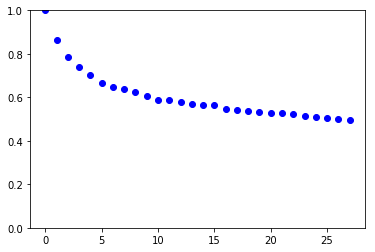

In [10]:
plt.plot(res[1:]/res[1], 'bo')
plt.ylim(0,1)
res

We'll choose default definition - to be in delinquency for **more than five days**, since after five days recovery rate is decreasing slowly.

**Calculating target variable**

We exclude all applications with term more than 60 days, since company are not going to credit them in future. And we need to exclude all loans granted for last 60 days + 6 days, otherwise we can't calculate target variable

In [11]:
applications = applications[applications['Term'] <= 60]
applications['app_dt'] = pd.to_datetime(applications['app_dt'], format = '%Y-%m-%d')
applications = applications[applications['app_dt'] <= '2018-10-10']

Add flag that loan was granted:

In [12]:
applications['granted'] = 0
applications.loc[applications['app_id'].isin(status[status['decision'] == 1]['app_id']),'granted'] = 1
applications['granted'].mean()

0.8019898082989566

Check stability of granted rate:

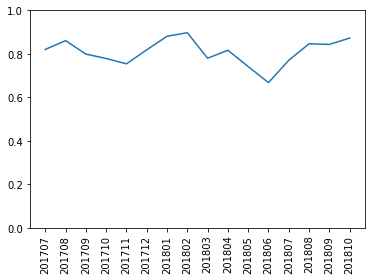

In [13]:
applications['month_gr'] = applications['app_dt'].apply(lambda x: str(x.year*100+x.month))
res = applications[['month_gr', 'granted']].groupby('month_gr').mean().sort_values(by = ['month_gr'])
plt.plot(res)
plt.xticks(rotation='vertical');
plt.ylim((0,1));

There is a fall in June-2018, but in general it's stable and there is no trends

Leave only granted applications:

In [14]:
applications = applications[applications['granted'] == 1]

There is no data for app_id = 12558 in portfolio, delete this one application (otherwise the next script has an error):

In [15]:
applications = applications[applications['app_id'] != 12558]

In [16]:
%%time
for i in applications['app_id']:
    dt = pd.to_datetime(applications[applications['app_id'] == i]['app_dt'].values[0])
    client_id = applications[applications['app_id'] == i]['client_id'].values[0]
    term = int(applications[applications['app_id'] == i]['Term'].values[0])
    a = portfolio.loc[(portfolio['report_dt'] >= dt + timedelta(term+2)) & (portfolio['report_dt'] <= dt + timedelta(term+6)) & (portfolio['client_id'] == client_id), ['client_id', 'delq']].groupby('client_id').min()
    applications.loc[applications['app_id'] == i, 'target'] = a['delq'].values[0]

Wall time: 1min 23s


In [17]:
applications['target'].mean()

0.12528370403994554

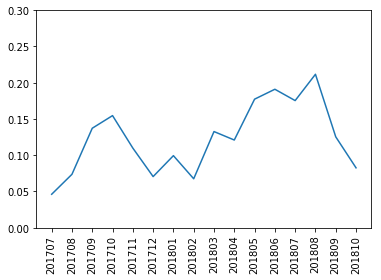

In [18]:
res = applications[['month_gr', 'target']].groupby('month_gr').mean().sort_values(by = ['month_gr'])
plt.plot(res)
plt.xticks(rotation='vertical');
plt.ylim((0, 0.3));

Default rate is less stable because one client can take more than one loan. And bad rate strongly depends on such clients (if they are good or bad):

In [19]:
applications[['client_id', 'app_id']].groupby('client_id').count().reset_index().sort_values(by = 'app_id', ascending = False).head(5)

,client_id,app_id
291,15583.0,314
498,19738.0,254
219,13026.0,253
451,19530.0,234
290,15579.0,194


To avoid it we'll leave only one active loan per one client per one time moment, e.g. if client took a loan on 1st of January for 30 days, we'll exclude all granted loans of this client before 31th of January.

In [20]:
%%time
client_id = 0
applications = applications.sort_values(by = ['client_id' , 'app_dt', 'app_id'])
applications['sample'] = 0

for i in applications['app_id']:
    if client_id != applications[applications['app_id'] == i]['client_id'].values[0]:
        client_id = applications[applications['app_id'] == i]['client_id'].values[0]
        final_dt = pd.to_datetime(applications[applications['app_id'] == i]['app_dt'].values[0], format = '%Y-%m-%d') + timedelta(int(applications[applications['app_id'] == i]['Term'].values[0]))
        applications.loc[applications['app_id'] == i, 'sample'] = 1    
    else:
        if pd.to_datetime(applications[applications['app_id'] == i]['app_dt'].values[0], format = '%Y-%m-%d') >= final_dt:
            final_dt = pd.to_datetime(applications[applications['app_id'] == i]['app_dt'].values[0], format = '%Y-%m-%d') + timedelta(int(applications[applications['app_id'] == i]['Term'].values[0]))
            applications.loc[applications['app_id'] == i, 'sample'] = 1   

Wall time: 16.9 s


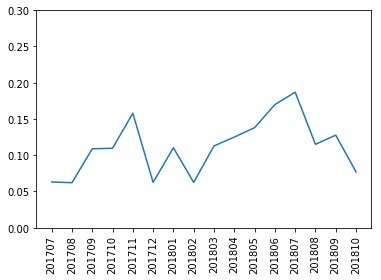

In [21]:
res = applications[applications['sample'] == 1][['month_gr', 'target']].groupby('month_gr').mean().sort_values(by = ['month_gr'])
plt.plot(res)
plt.xticks(rotation='vertical');
plt.ylim((0, 0.3));

Now it's better. But we can see growth in summer 2018. At the same time we saw decsrease of approval rate at the same period, it means that clients flow was worst at that time.

Now we have not too much data:

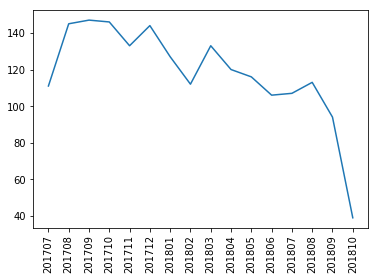

In [22]:
res = applications[applications['sample'] == 1][['month_gr', 'target']].groupby('month_gr').count().sort_values(by = ['month_gr'])
plt.plot(res)
plt.xticks(rotation='vertical');

## 7. Data preprocessing

Check NaN:

In [166]:
applications.columns

Index(['id', 'Term', 'expired_date', 'loans_amount', 'loans_cnt',
       'paid_amount', 'paid_cnt', 'pretention', 'location_country',
       'location_city', 'app_dt', 'verif_data', 'verif_doc', 'verif_appl',
       'verif_addres', 'doc_date', 'client_date', 'credit_status', 'rating',
       'rating2', 'amount_issued', 'amount_return', 'friends', 'app_id',
       'client_id', 'granted', 'month_gr', 'target', 'sample', 'doc_date_i',
       'client_date_i'],
      dtype='object')

In [168]:
applications[['Term', 'expired_date', 'loans_amount', 'loans_cnt',
       'paid_amount', 'paid_cnt', 'pretention', 'location_country',
       'location_city', 'app_dt', 'verif_data', 'verif_doc', 'verif_appl',
       'verif_addres', 'doc_date', 'client_date', 'credit_status', 'rating',
       'rating2', 'amount_issued', 'amount_return', 'friends']].describe()

,Term,loans_amount,loans_cnt,paid_amount,paid_cnt,pretention,verif_data,verif_doc,verif_appl,verif_addres,credit_status,rating,rating2,amount_issued,amount_return,friends
count,6609.000000,6.609000e+03,6609.000000,6.609000e+03,6609.000000,4034.000000,6608.000000,6604.000000,6608.000000,6609.000000,6609.000000,6609.000000,6609.000000,6609.000000,6609.000000,6609.000000
mean,34.088213,2.184977e+06,604.711303,2.101542e+06,578.062944,0.115022,2.948245,1.101605,1.552966,1.550613,1.830080,217.403995,216.906945,10919.961934,11797.881521,118.892419
std,15.627277,2.806990e+06,692.752587,2.736434e+06,675.952390,0.598086,0.232223,0.302151,0.497224,0.497469,0.397514,134.760104,1871.646780,26201.328238,27693.195426,121.744662
min,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,61.000000,62.220000,0.000000
25%,30.000000,4.107941e+05,140.000000,3.816386e+05,131.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000,127.000000,0.000000,3050.000000,3355.000000,43.000000
50%,30.000000,1.136880e+06,346.000000,1.072187e+06,324.000000,0.000000,3.000000,1.000000,2.000000,2.000000,2.000000,198.000000,4.000000,6100.000000,6466.000000,77.000000
75%,41.000000,2.788831e+06,773.000000,2.674457e+06,735.000000,0.000000,3.000000,1.000000,2.000000,2.000000,2.000000,281.000000,73.000000,9150.000000,9760.000000,159.000000
max,60.000000,1.621004e+07,3531.000000,1.525064e+07,3470.000000,12.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1060.000000,71874.000000,610000.000000,652700.000000,592.000000


**pretention:**

In [170]:
applications[['pretention', 'month_gr']].groupby('month_gr').count()

,pretention
month_gr,
201707,0
201708,0
201709,0
201710,0
201711,0
201712,157
201801,463
201802,415
201803,558


Since one third of varible has missing values, we'll not use it

Check **verif_doc**:

In [173]:
applications[['verif_doc', 'app_id']].groupby('verif_doc').count()

,app_id
verif_doc,
1.0,5933
2.0,671


In [174]:
applications['verif_doc'] = applications['verif_doc'].fillna(0)

Check **verif_appl**:

In [189]:
applications[['verif_appl', 'app_id']].groupby('verif_appl').count()

,app_id
verif_appl,
1.0,2954
2.0,3654


In [190]:
applications['verif_appl'] = applications['verif_appl'].fillna(0)

Check **location_country** and **location_city**:

In [204]:
applications['location_country'] = applications['location_country'].fillna('n\a')
applications['location_city'] = applications['location_city'].fillna('n\a')

## 9. Creation of new features

Add new features: time from client registration and from issued of document (for both than more then better)

In [165]:
applications['doc_date_i'] = ((pd.to_datetime(applications['app_dt'], format = '%Y-%m-%d')-pd.to_datetime(applications['doc_date'], format = '%Y-%m-%d')).dt.days/365.25).fillna(0)
applications['client_date_i'] = (pd.to_datetime(applications['app_dt'], format = '%Y-%m-%d')-pd.to_datetime(applications['client_date'], format = '%Y-%m-%d')).dt.days/365.25

Add new feature: average interest rate (monthly). According to current loan process, client accepts maximum rate that he agrees. Process won't be changed, therefore we can use such variable 

In [226]:
applications['ir'] = (applications['amount_return'] - applications['amount_issued'])/(applications['Term']/30)/applications['amount_issued']

In [412]:
applications['pti'] = (applications['loans_amount'] - applications['paid_amount'] + applications['amount_return'])/applications['paid_amount']

## 3. Primary visual data analysis

In [233]:
appl_short = applications[applications['sample'] == 1]

In [234]:
appl_short.columns

Index(['id', 'Term', 'expired_date', 'loans_amount', 'loans_cnt',
       'paid_amount', 'paid_cnt', 'pretention', 'location_country',
       'location_city', 'app_dt', 'verif_data', 'verif_doc', 'verif_appl',
       'verif_addres', 'doc_date', 'client_date', 'credit_status', 'rating',
       'rating2', 'amount_issued', 'amount_return', 'friends', 'app_id',
       'client_id', 'granted', 'month_gr', 'target', 'sample', 'doc_date_i',
       'client_date_i', 'ir'],
      dtype='object')

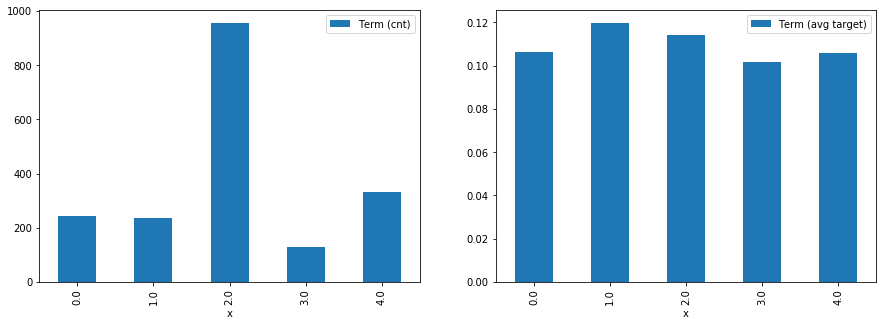

In [177]:
var = 'Term'
ratio = 15
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

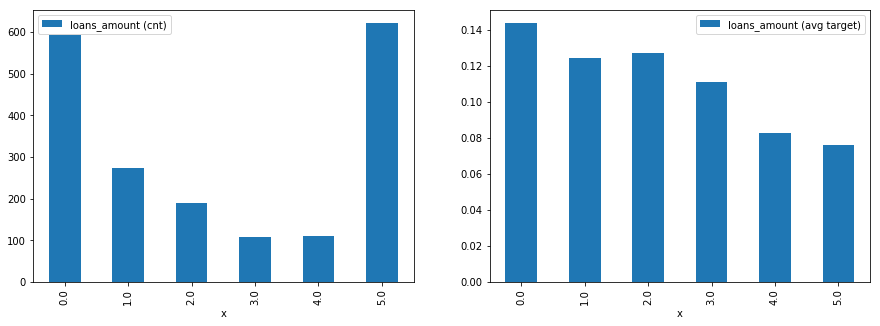

In [178]:
var = 'loans_amount'
ratio = 200000
limit = 5
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

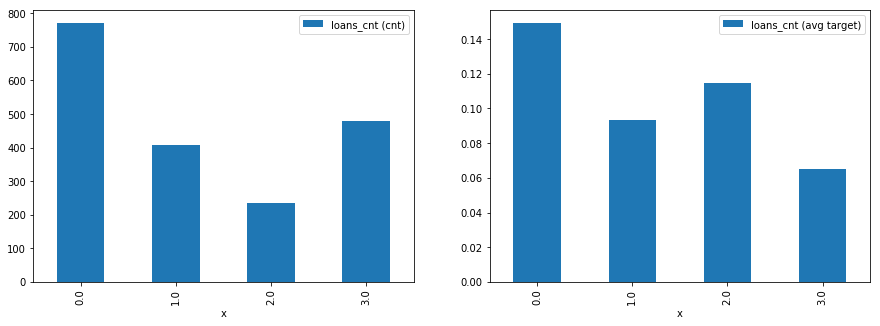

In [179]:
var = 'loans_cnt'
ratio = 100
limit = 3
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

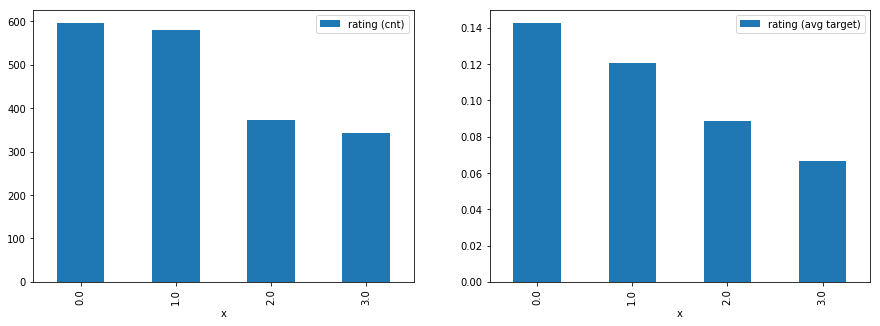

In [180]:
var = 'rating'
ratio = 100
limit = 3
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

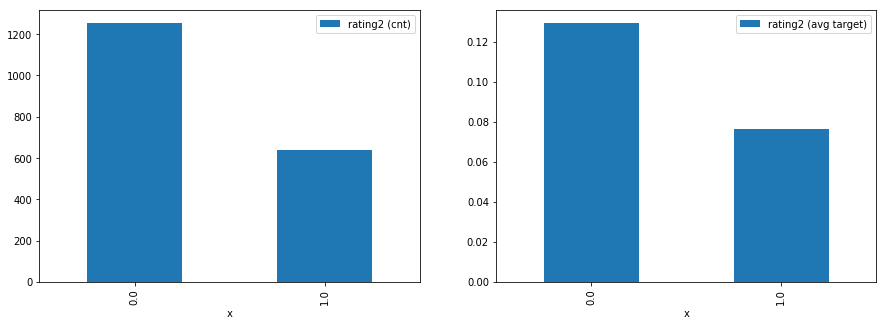

In [181]:
var = 'rating2'
ratio = 10
limit = 1
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

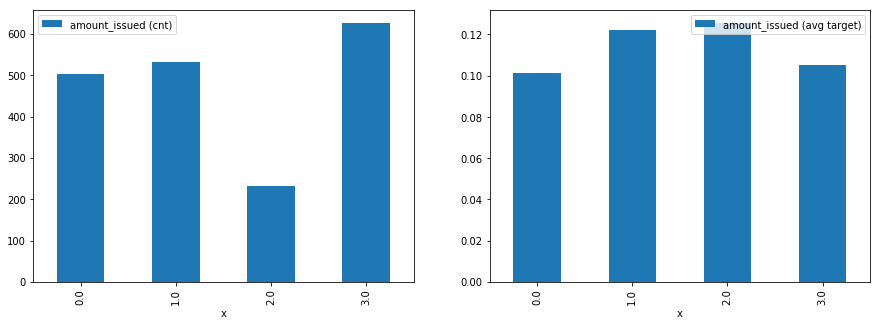

In [182]:
var = 'amount_issued'
ratio = 5000
limit = 3
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

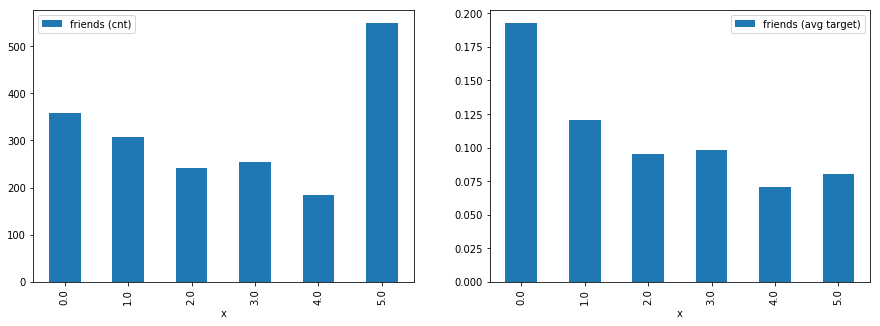

In [183]:
var = 'friends'
ratio = 15
limit = 5
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

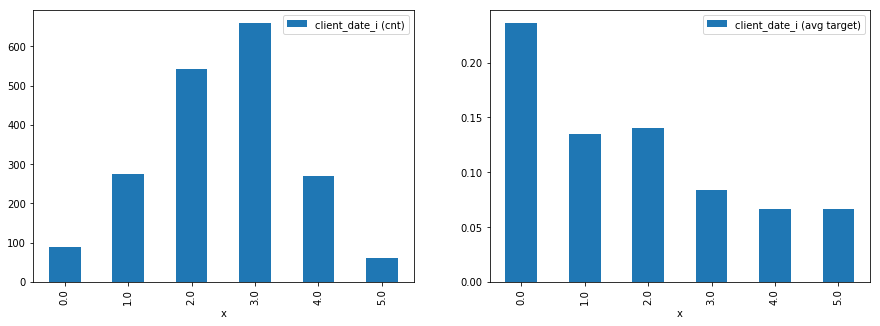

In [184]:
var = 'client_date_i'
ratio = 3
limit = 5
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

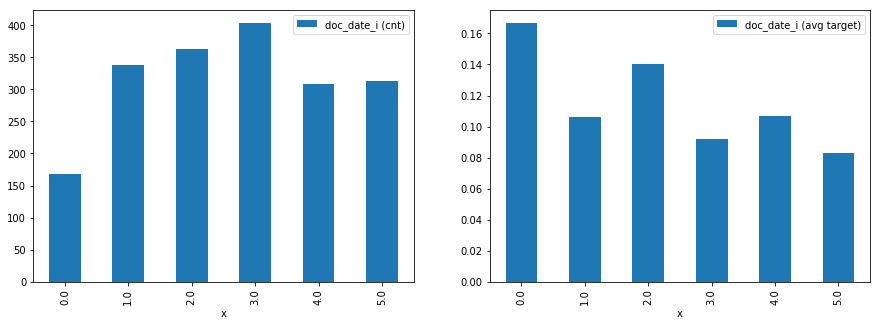

In [185]:
var = 'doc_date_i'
ratio = 3
limit = 5
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

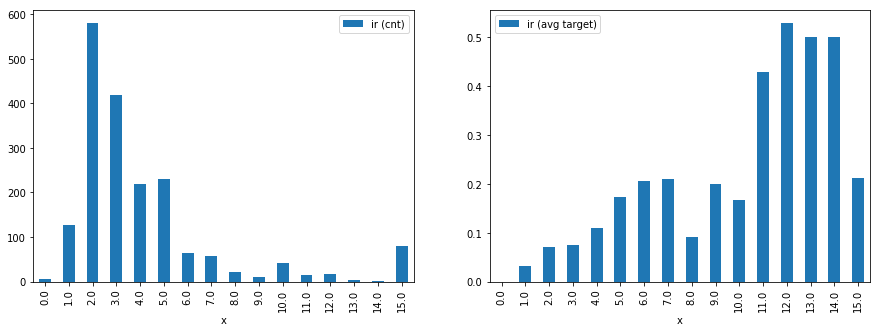

In [241]:
var = 'ir'
ratio = 0.02
limit = 15
plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (cnt)']).groupby('x').count().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());
plt.subplot(1,2,2)
pd.DataFrame(data = np.concatenate((np.asarray([appl_short[var].apply(lambda x: limit if int(x/ratio) > limit else int(x/ratio))]).T,
                                    appl_short[['target']]), axis = 1), 
             columns = ['x',
                        var + ' (avg target)']).groupby('x').mean().reset_index().sort_values(by = ['x']).plot(x = 'x', 
                                                                                                   kind = 'bar',
                                                                                                    ax=plt.gca());

Very high interest rate means very high risk. Decreasing of risk in the last bucket is due to clients with very short term (usualy, they have much higher interest rate)

## 5. Metrics selection

We need to split clients for "good" and "bad". But we don't need to split "bad" clients from "very bad" clients. Therefore, firstly, we decline very bad clients - with very high interest rate.
After we'll use standard metric for bank scoring - roc-auc.

In [249]:
df = appl_short[['target', 'ir', 'Term']]
df['Term_gr'] = df['Term'].apply(lambda x: 7 if x <= 7 else 29 if x <= 29 else 30 if x == 30 else 60)
df['ir_gr'] = df['ir'].apply(lambda x: 15 if int(x/0.02) > 15 else int(x/0.02))
df['cnt'] = 1
df2 = df.groupby(['Term_gr', 'ir_gr']).sum().reset_index()
df2['avg_target'] = df2['target']/df2['cnt']

In [251]:
df2[['Term_gr', 'ir_gr', 'avg_target', 'cnt']]

,Term_gr,ir_gr,avg_target,cnt
0,7,1,0.000000,1
1,7,2,0.250000,4
2,7,3,0.000000,10
3,7,4,0.000000,10
4,7,5,0.100000,10
5,7,6,0.250000,12
6,7,7,0.333333,9
7,7,8,0.000000,2
8,7,9,0.000000,1
9,7,10,0.000000,10


In [254]:
df = appl_short[['target', 'ir', 'Term']]
df['Term_gr'] = df['Term'].apply(lambda x: 7 if x <= 7 else 29 if x <= 29 else 30 if x == 30 else 60)
df['ir_gr'] = df['ir'].apply(lambda x: 11 if int(x/0.02) > 11 else 7 if int(x/0.02) >= 7 else 6)
df['cnt'] = 1
df2 = df.groupby(['Term_gr', 'ir_gr']).sum().reset_index()
df2['avg_target'] = df2['target']/df2['cnt']
df2[['Term_gr', 'ir_gr', 'avg_target', 'cnt']]

,Term_gr,ir_gr,avg_target,cnt
0,7,6,0.106383,47
1,7,7,0.166667,24
2,7,11,0.176471,51
3,29,6,0.066667,255
4,29,7,0.130435,69
5,29,11,0.303030,33
6,30,6,0.106821,777
7,30,7,0.307692,39
8,30,11,0.470588,17
9,60,6,0.084806,566


Finally, we'll decline clients with 
    - interest rate >= 0.13 if term >= 30
    - interest rate >= 0.21 if term > 7

In [413]:
applications['auto_decl'] = 0
applications.loc[(applications['ir'] >= 0.13) & (applications['Term'] >= 30),'auto_decl'] = 1
applications.loc[(applications['ir'] >= 0.21) & (applications['Term'] > 7),'auto_decl'] = 1
appl_short = applications[(applications['sample'] == 1) & (applications['auto_decl'] == 0)]

In [414]:
applications[(applications['sample'] == 1) & (applications['auto_decl'] == 0)]['target'].mean(), \
applications[(applications['sample'] == 1) & (applications['auto_decl'] == 1)]['target'].mean(), \
applications[(applications['sample'] == 1) & (applications['auto_decl'] == 0)]['target'].count(), \
applications[(applications['sample'] == 1) & (applications['auto_decl'] == 1)]['target'].count()

(0.09779536461277558, 0.3064516129032258, 1769, 124)

We decline 124 observations with risk rate more than 30%

## 6. Model selection

We'll choose catboost model since it works very good with categorial variables. 

In [452]:
appl_short = appl_short.sort_values(by = ['app_dt', 'app_id'])
X_train = appl_short[['location_country','location_city', 'verif_data', 'verif_doc', 'verif_appl',
                       'verif_addres', 'credit_status', 'Term', 'rating', 'pti',
                   'rating2', 'amount_issued', 'amount_return', 'friends', 'doc_date_i','client_date_i', 'ir']].values
y_train = appl_short['target'].values

In [453]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [483]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(random_seed = 17, thread_count = 4, verbose = False)
model.fit(X_train_part, y_train_part, cat_features = [0,1,2,3,4,5,6])

In [485]:
cb_train_pred = model.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, cb_train_pred)

0.655044784958176

## 8. Cross-validation and adjustment of model hyperparameters

In [443]:
X_train = appl_short[['location_country','location_city', 'verif_data', 'verif_doc', 'verif_appl',
                       'verif_addres', 'credit_status', 'Term', 'rating', 'pti',
                   'rating2', 'amount_issued', 'amount_return', 'friends', 'doc_date_i','client_date_i', 'ir']].values
y_train = appl_short['target'].values

We'll find the best values of max_depth and n_estimators, we'll assume parameter cv = 3

In [526]:
%%time
res = []
cv = 3

step = int(X_train.shape[0]/(cv + 1))

for max_depth in range(2,7,2):
    for n_estimators in range(500, 2000, 500):            
        for i in range(1,cv+1):
            X_train_part = X_train[:step*i-1,:]
            y_train_part = y_train[:step*i-1]
            if i < cv:
                X_valid = X_train[step*i:step*(i+1),:]
                y_valid = y_train[step*i:step*(i+1)]
            else:
                X_valid = X_train[step*i:,:]
                y_valid = y_train[step*i:]

            model = CatBoostClassifier(random_seed = 17, thread_count = 4, verbose = False,
                                       max_depth = max_depth, n_estimators = n_estimators)
            model.fit(X_train_part, y_train_part, cat_features = [0,1,2,3,4,5,6])
            
            cb_train_pred = model.predict_proba(X_train_part)[:, 1]
            train_res = roc_auc_score(y_train_part, cb_train_pred)
            
            cb_valid_pred = model.predict_proba(X_valid)[:, 1]
            cv_res = roc_auc_score(y_valid, cb_valid_pred)
            res.append([max_depth, n_estimators, i, train_res, cv_res])
            print(max_depth, n_estimators, i, train_res, cv_res)


2 500 1 0.9236883942766295 0.6617675128841383
2 500 2 0.8657703365465923 0.6279423392737669
2 500 3 0.8184623408231562 0.6174081920903955
2 1000 1 0.9288914583032231 0.6494241903671184
2 1000 2 0.8671740233384069 0.6419317559759139
2 1000 3 0.8308705289234648 0.6204978813559321
2 1500 1 0.9319988437635497 0.6491696888719222
2 1500 2 0.8711821410451547 0.6328690468949577
2 1500 3 0.8290161820736813 0.628222104519774
4 500 1 0.9799103916750975 0.6246739199592798
4 500 2 0.9448503297818367 0.6424183443829452
4 500 3 0.8973227867356252 0.623675847457627
4 1000 1 0.9831623066917186 0.6183113825793727
4 1000 2 0.952004058853374 0.6444255215619488
4 1000 3 0.9069929158155504 0.6274276129943503
4 1500 1 0.984029484029484 0.6353629827575237
4 1500 2 0.9532048029764925 0.6286722218843136
4 1500 3 0.9046822257957031 0.6264124293785311
6 500 1 0.9963144963144963 0.6298275752370046
6 500 2 0.9838998816167767 0.631470105224743
6 500 3 0.9297231518101613 0.6307821327683616
6 1000 1 0.9985547044370574

In [529]:
res = pd.DataFrame(data = res, columns = ['max_depth', 'n_estimators', 'cv_iter', 'train_res', 'cv_res'])
res[['max_depth', 'n_estimators', 'train_res', 'cv_res']].groupby(['max_depth', 'n_estimators']).\
    mean().reset_index().sort_values(by = ['cv_res'], ascending = False)

,max_depth,n_estimators,train_res,cv_res
1,2,1000,0.875645,0.637285
2,2,1500,0.877399,0.636754
0,2,500,0.869307,0.635706
6,6,500,0.969979,0.630693
3,4,500,0.940695,0.630256
5,4,1500,0.947306,0.630149
4,4,1000,0.947386,0.630055
7,6,1000,0.976956,0.629623
8,6,1500,0.979116,0.623608


## 10. Plotting training and validation curves

Max_depth:

Wall time: 2min 4s


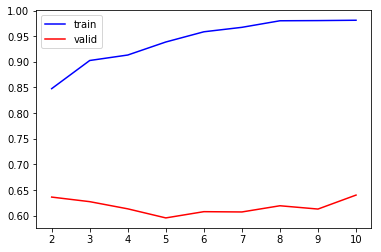

In [522]:
%%time
res = []
cv = 3

step = int(X_train.shape[0]/(cv + 1))

n_estimators = 100

for max_depth in range(2,11):
    for i in range(1,cv+1):
        X_train_part = X_train[:step*i-1,:]
        y_train_part = y_train[:step*i-1]
        if i < cv:
            X_valid = X_train[step*i:step*(i+1),:]
            y_valid = y_train[step*i:step*(i+1)]
        else:
            X_valid = X_train[step*i:,:]
            y_valid = y_train[step*i:]

        model = CatBoostClassifier(random_seed = 17, thread_count = 4, verbose = False,
                                   max_depth = max_depth, n_estimators = n_estimators)
        model.fit(X_train_part, y_train_part, cat_features = [0,1,2,3,4,5,6])

        cb_train_pred = model.predict_proba(X_train_part)[:, 1]
        train_res = roc_auc_score(y_train_part, cb_train_pred)

        cb_valid_pred = model.predict_proba(X_valid)[:, 1]
        cv_res = roc_auc_score(y_valid, cb_valid_pred)
        res.append([max_depth, n_estimators, i, train_res, cv_res])

df_res = pd.DataFrame(data = res, columns = ['max_depth', 'n_estimators', 'cv_iter', 'train_res', 'cv_res'])
x = np.linspace(2,10,9)
y1 = df_res[['max_depth', 'n_estimators', 'train_res']].groupby(['max_depth', 'n_estimators']).\
        mean()['train_res'].values
y2 = df_res[['max_depth', 'n_estimators', 'cv_res']].groupby(['max_depth', 'n_estimators']).\
        mean().reset_index()['cv_res'].values
plt.plot(x, y1, '-b', label = 'train')
plt.plot(x, y2, '-r', label = 'valid')
plt.legend(loc='upper left')

n_estimators:

Wall time: 3min 54s


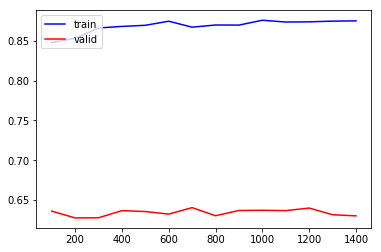

In [523]:
%%time
res = []
cv = 3

step = int(X_train.shape[0]/(cv + 1))

max_depth = 2

for n_estimators in range(100,1500,100):
    for i in range(1,cv+1):
        X_train_part = X_train[:step*i-1,:]
        y_train_part = y_train[:step*i-1]
        if i < cv:
            X_valid = X_train[step*i:step*(i+1),:]
            y_valid = y_train[step*i:step*(i+1)]
        else:
            X_valid = X_train[step*i:,:]
            y_valid = y_train[step*i:]

        model = CatBoostClassifier(random_seed = 17, thread_count = 4, verbose = False,
                                   max_depth = max_depth, n_estimators = n_estimators)
        model.fit(X_train_part, y_train_part, cat_features = [0,1,2,3,4,5,6])

        cb_train_pred = model.predict_proba(X_train_part)[:, 1]
        train_res = roc_auc_score(y_train_part, cb_train_pred)

        cb_valid_pred = model.predict_proba(X_valid)[:, 1]
        cv_res = roc_auc_score(y_valid, cb_valid_pred)
        res.append([max_depth, n_estimators, i, train_res, cv_res])
        
df_res = pd.DataFrame(data = res, columns = ['max_depth', 'n_estimators', 'cv_iter', 'train_res', 'cv_res'])
x = np.linspace(100,1400,14)
y1 = df_res[['max_depth', 'n_estimators', 'train_res']].groupby(['max_depth', 'n_estimators']).\
        mean()['train_res'].values
y2 = df_res[['max_depth', 'n_estimators', 'cv_res']].groupby(['max_depth', 'n_estimators']).\
        mean().reset_index()['cv_res'].values
plt.plot(x, y1, '-b', label = 'train')
plt.plot(x, y2, '-r', label = 'valid')
plt.legend(loc='upper left')

## 11. Prediction for test or hold-out samples

**Final model:**

In [600]:
X_train = appl_short[['location_country','location_city', 'verif_data', 'verif_doc', 'verif_appl',
                       'verif_addres', 'credit_status', 'Term', 'rating', 'pti',
                   'rating2', 'amount_issued', 'amount_return', 'friends', 'doc_date_i','client_date_i', 'ir']].values
y_train = appl_short['target'].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)
model = CatBoostClassifier(random_seed = 17, thread_count = 4, verbose = False,
                            max_depth = 2, n_estimators = 1000)
model.fit(X_train_part, y_train_part, cat_features = [0,1,2,3,4,5,6])
cb_train_pred = model.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, cb_train_pred)

0.6176993115700643

This result is less than we have at first iteration of model, but it seems to be more stable.

## 12. Conclusions

First, we need to set up cut-off, since the main goal of this project is to estimate potential volume of loans. To set up cut-off, we need to choose value of score according of risk level. Acceptable risk level is 2% (calculated from margin)

In [603]:
res = []
res = np.concatenate((np.asarray([cb_train_pred]).T, np.asarray([y_valid]).T), axis = 1)
df_res = pd.DataFrame(data = res, columns = ['score', 'bad'])
df_res = df_res.sort_values(by = ['score'])
df_res['score_gr'] = df_res['score'].apply(lambda x: 'good' if x <= 0.027 else 'bad')
print(df_res[['score_gr', 'bad']].groupby('score_gr').mean(), df_res[['score_gr', 'bad']].groupby('score_gr').count())

               bad
score_gr          
bad       0.112205
good      0.000000           bad
score_gr     
bad       508
good       23


Share of good clients is too small

**Conclusion:** 

1. To build model only on application data is not possible, additional data should be used
2. To include in the model variable of credit history (now it's not available in credit process)